Dimensionality Reduction
---
##### 14Dec2018
Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [2]:
import sys
sys.path.append('../')
from fcc_DRs import *
from fcc_utils import *

Using TensorFlow backend.
/Users/cody/.virtualenvs/lau_lab/lib/python3.6/site-packages/kopt/config.py:60: YAMLLoadWarning: 
  *** Calling yaml.load() without Loader=... is deprecated.
  *** The default Loader is unsafe.
  *** Please read https://msg.pyyaml.org/load for full details.
  _config = yaml.load(open(_config_path))


---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [3]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [4]:
P14Retina.data.shape

(6600, 20478)

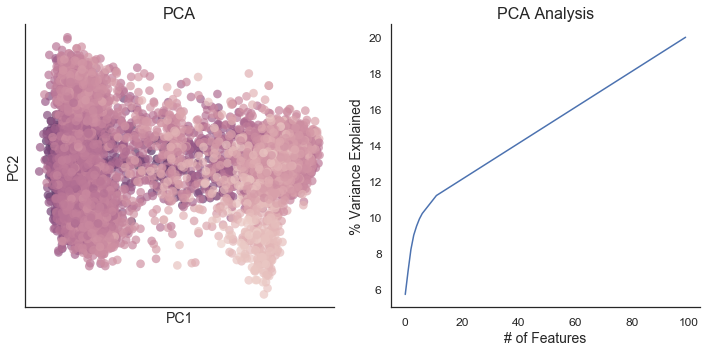

In [5]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot()

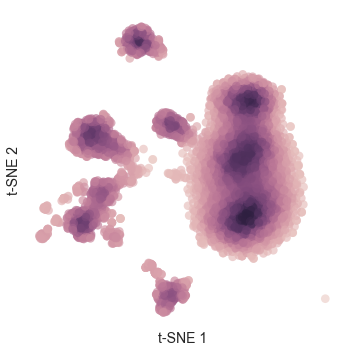

CPU times: user 1min 6s, sys: 3.48 s, total: 1min 10s
Wall time: 1min 12s


In [6]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1358b9ba8>)

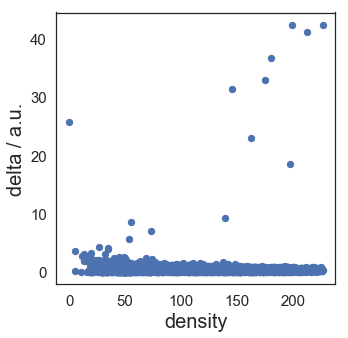

In [7]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x13337c630>)

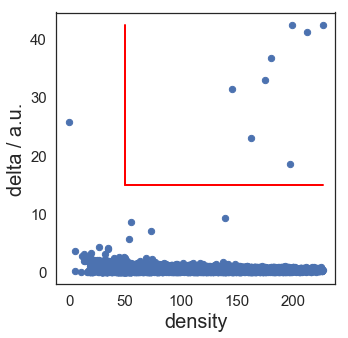

In [8]:
P14Retina_tSNE.clu.assign(50,15) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

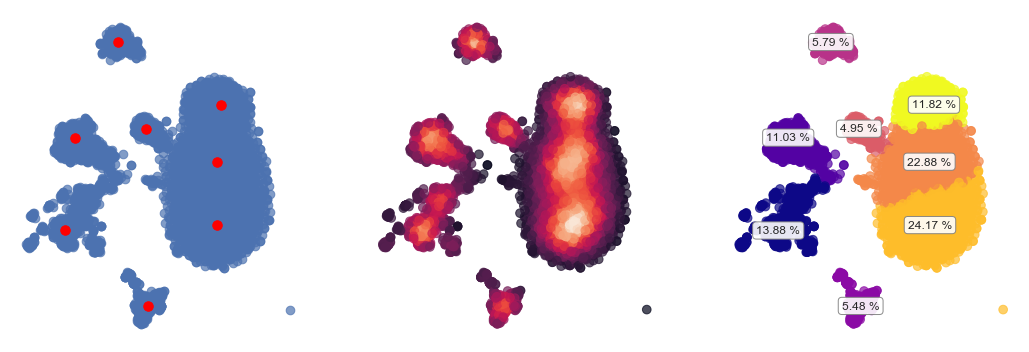

In [9]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [10]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.508419394493103



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [39]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [40]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

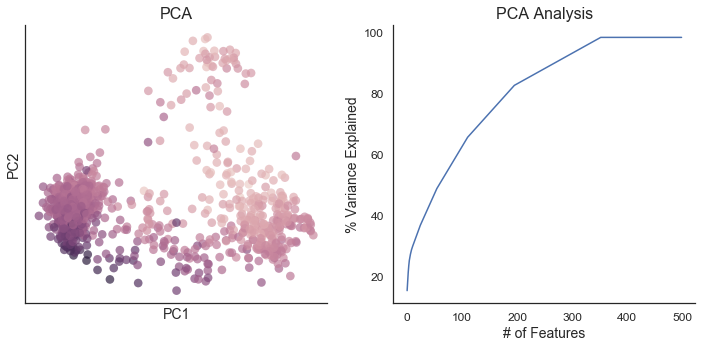

In [41]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot()

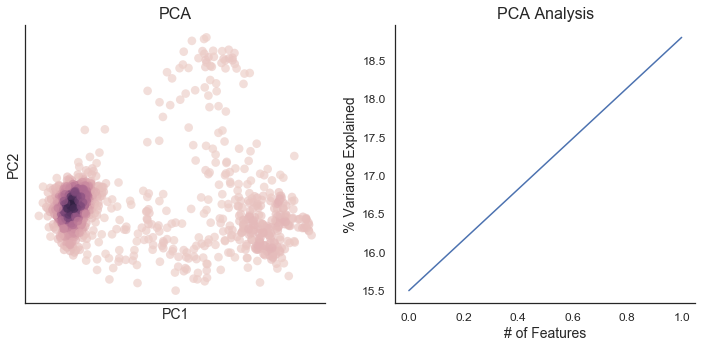

In [42]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot()

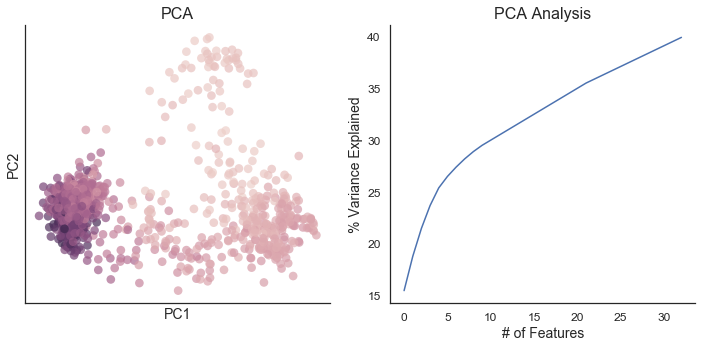

In [43]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot()

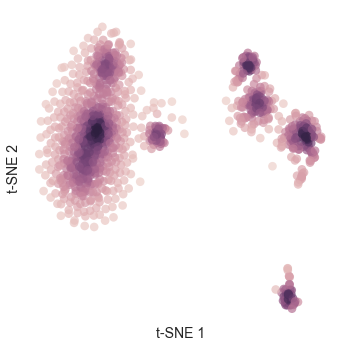

In [44]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

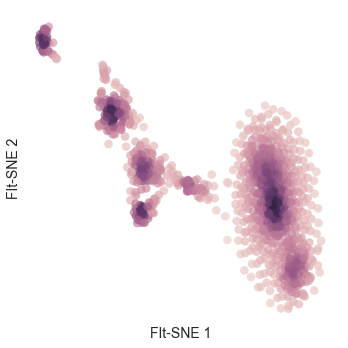

In [45]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

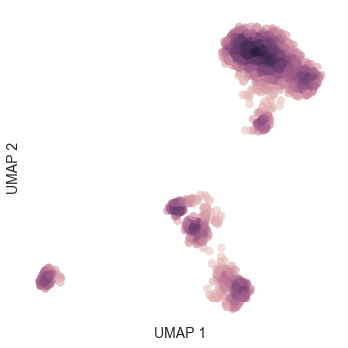

In [46]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [47]:
%time P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts of 500 selected features

DCA: Successfully preprocessed 500 genes and 1003 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 25.5 s, sys: 1.62 s, total: 27.1 s
Wall time: 15.9 s


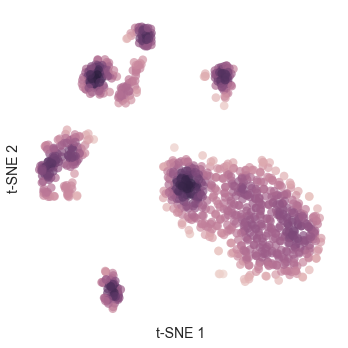

In [48]:
test = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(norm='l1'), perplexity=30) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

##### Use scVI to reduce dimensions

In [1]:
from scvi.dataset import CsvDataset
import urllib
from scvi.models import *
from scvi.inference import UnsupervisedTrainer
n_epochs=400 
lr=1e-3
use_batches=False
use_cuda=True

In [9]:
# Loading a local dataset into scVI
P14Retina1_scVI = CsvDataset('GSM1626793_P14Retina_1.digital_expression.csv.gz', 
                               save_path='inputs/', compression='gzip') 

File inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz already downloaded
Preprocessing dataset
Finished preprocessing dataset
Downsampling from 20478 to 600 genes
Downsampling from 6600 to 6600 cells


In [11]:
vae = VAE(P14Retina1_scVI.nb_genes, n_batch=P14Retina1_scVI.n_batches * use_batches)
trainer = UnsupervisedTrainer(vae,
                              P14Retina1_scVI,
                              train_size=0.75,
                              use_cuda=use_cuda,
                              frequency=5)
trainer.train(n_epochs=n_epochs, lr=lr)

training: 100%|████████████████████████████████████████████████████████████████████████████| 400/400 [08:55<00:00,  1.77s/it]


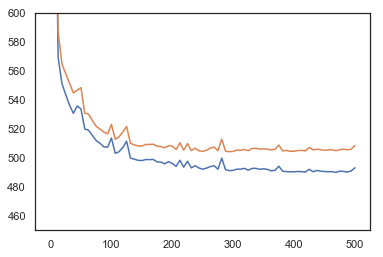

In [15]:
ll_train_set = trainer.history["ll_train_set"]
ll_test_set = trainer.history["ll_test_set"]
x = np.linspace(0,500,(len(ll_train_set)))
plt.plot(x, ll_train_set)
plt.plot(x, ll_test_set)
plt.ylim(450,600)
plt.show()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [38]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [49]:
k = 30 # choose value for K-nearest neighbor calculations

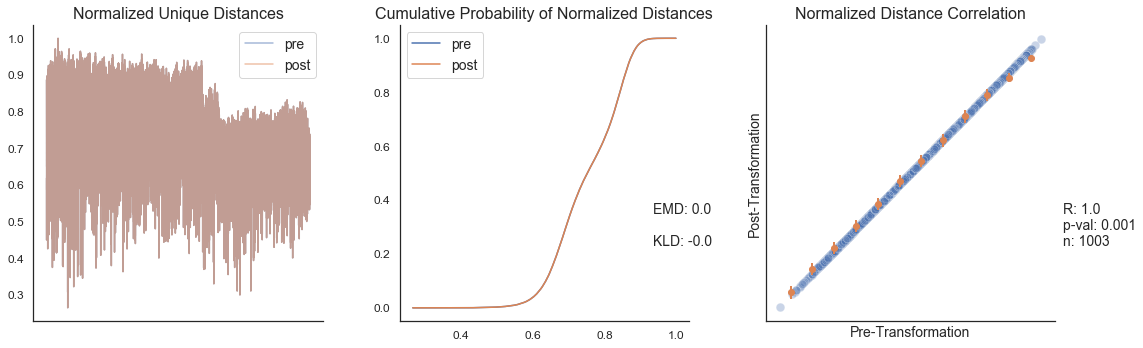

Knn Preservation: 100.0

CPU times: user 31.6 s, sys: 5.12 s, total: 36.8 s
Wall time: 37 s


In [50]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

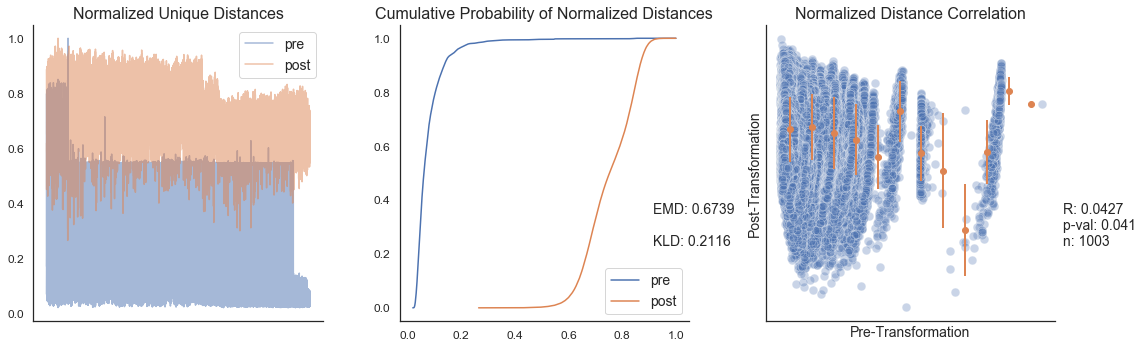

Knn Preservation: 95.5895

CPU times: user 32 s, sys: 5.71 s, total: 37.7 s
Wall time: 37.7 s


In [51]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

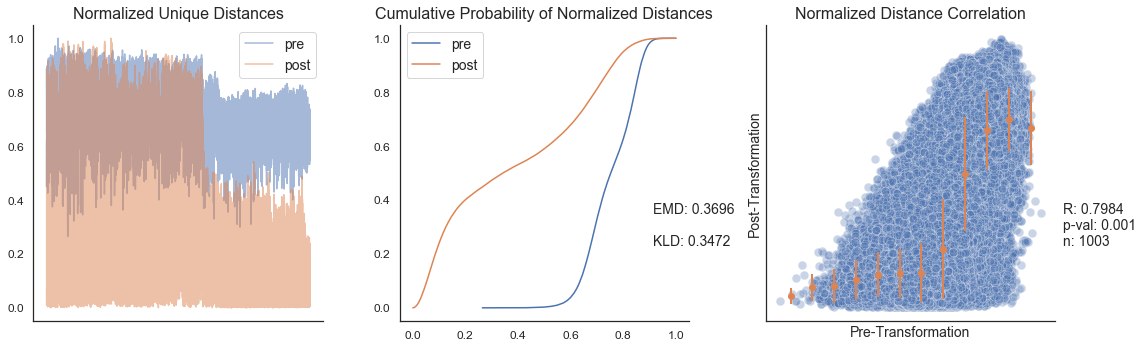

Knn Preservation: 95.9116

CPU times: user 26.9 s, sys: 4.48 s, total: 31.3 s
Wall time: 30.9 s


In [52]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

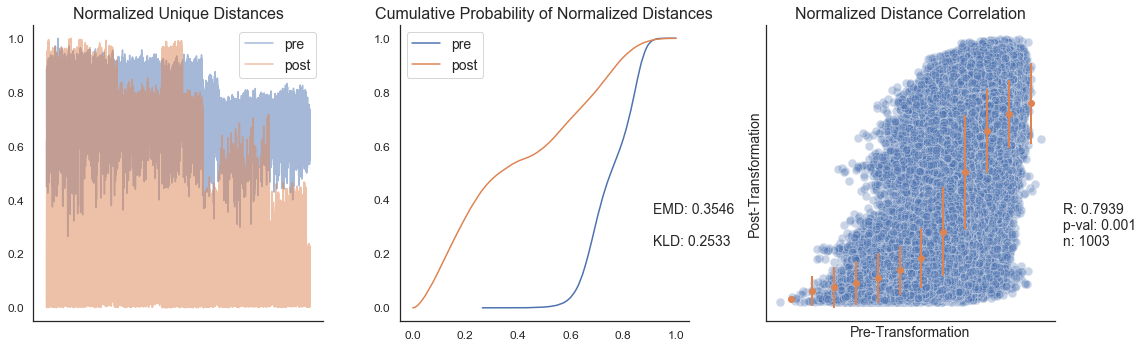

Knn Preservation: 95.6142

CPU times: user 31.7 s, sys: 4.68 s, total: 36.4 s
Wall time: 36.8 s


In [53]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

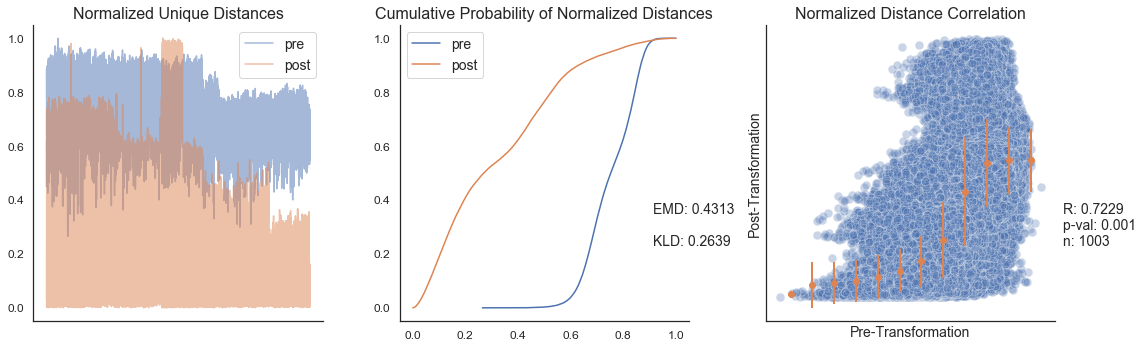

Knn Preservation: 95.6146

CPU times: user 34.5 s, sys: 5.83 s, total: 40.3 s
Wall time: 41 s


In [54]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

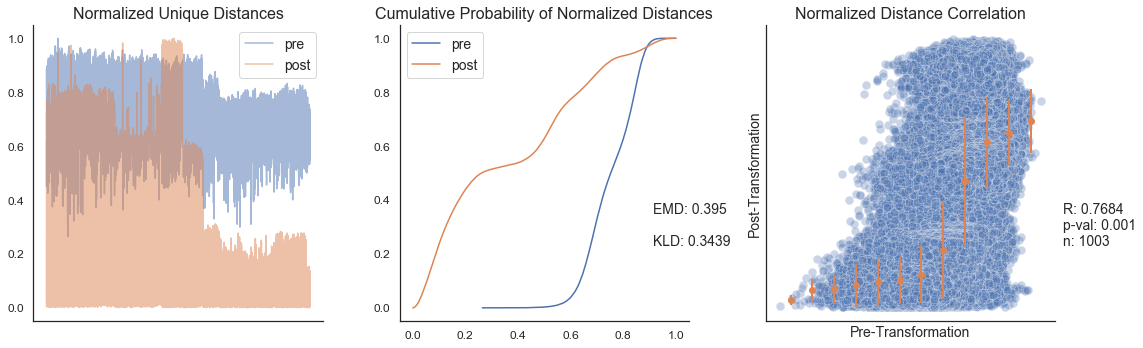

Knn Preservation: 95.3211

CPU times: user 33.1 s, sys: 4.33 s, total: 37.4 s
Wall time: 37 s


In [55]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

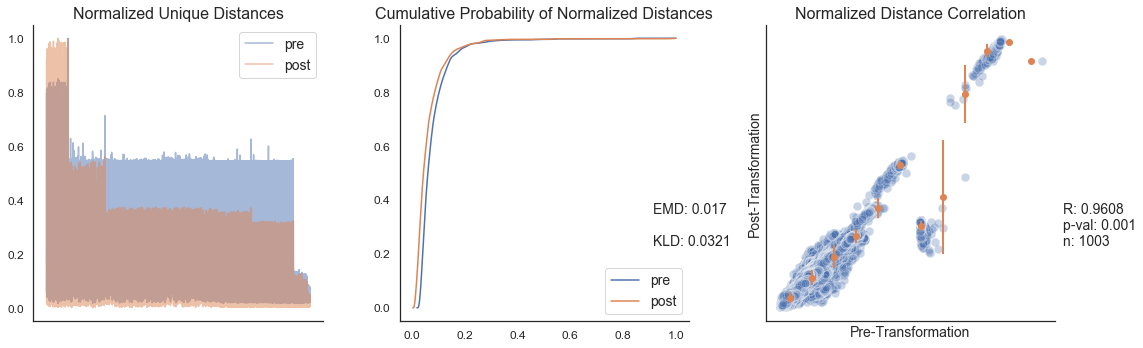

Knn Preservation: 96.5833

CPU times: user 29.7 s, sys: 5.17 s, total: 34.9 s
Wall time: 34.9 s


In [56]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

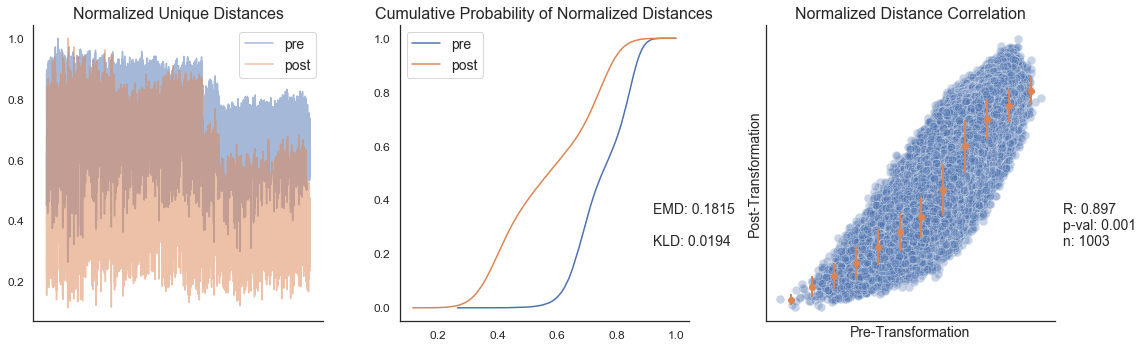

Knn Preservation: 96.9599

CPU times: user 29 s, sys: 5.29 s, total: 34.3 s
Wall time: 36.5 s


In [57]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

---
#### 3. repeat for continuous dataset

---
#### 3.0. read in continuous dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [59]:
%time qi = RNA_counts.from_file('../inputs/qi_s1_edited_all.csv.gz', cells_axis=0, labels=[None,None])

CPU times: user 16.5 s, sys: 1.17 s, total: 17.7 s
Wall time: 18.4 s


In [60]:
qi.data.shape

(1595, 25507)

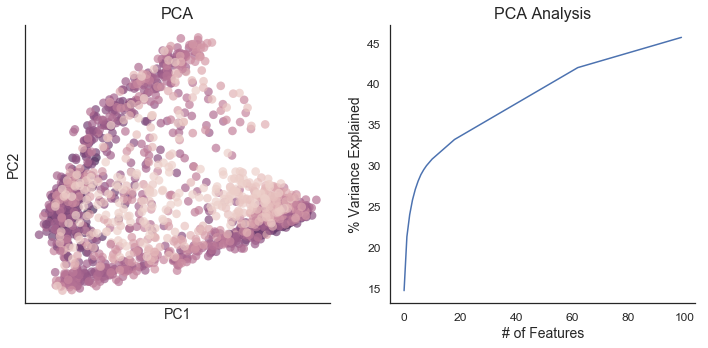

In [62]:
qi_PCA100 = fcc_PCA(qi.arcsinh_norm(norm='l1'), n_components=100)
qi_PCA100.plot()

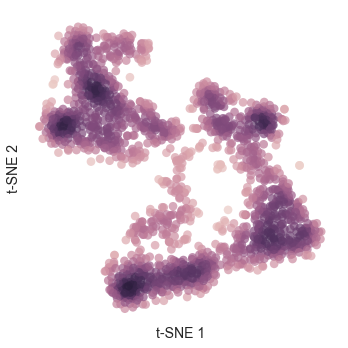

CPU times: user 10.4 s, sys: 365 ms, total: 10.8 s
Wall time: 10.8 s


In [63]:
%%time 
qi_tSNE = fcc_tSNE(qi_PCA100.results, perplexity=30) # use standard perplexity of 30 here
qi_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x130ea8390>)

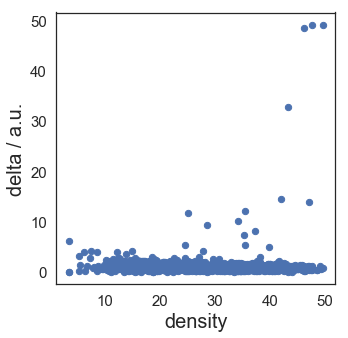

In [64]:
qi_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x12ca64668>)

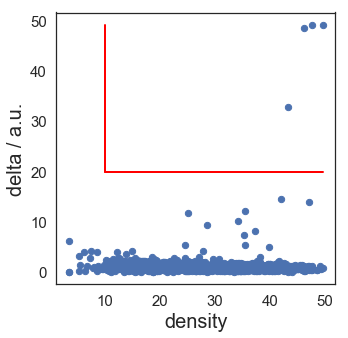

In [65]:
qi_tSNE.clu.assign(10,20) # assign cluster center cutoffs
qi_tSNE.clu.draw_decision_graph(min_delta=qi_tSNE.clu.min_delta, min_density=qi_tSNE.clu.min_density) # plot chosen density-peak cluster centers

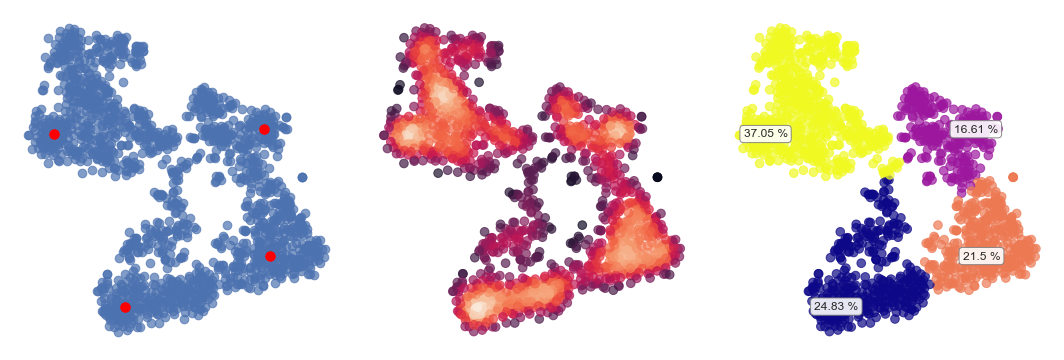

In [66]:
qi_tSNE.plot_clusters() # visualize clustering

In [67]:
print('Silhouette Score: {}\n'.format(qi_tSNE.silhouette_score()))
qi_tSNE.cluster_counts()

Silhouette Score: 0.5259974598884583

396 cells in cluster 0 (24.828 %)

265 cells in cluster 1 (16.614 %)

343 cells in cluster 2 (21.505 %)

591 cells in cluster 3 (37.053 %)



---
#### 3.1. feature-select continuous dataset and perform DRs
* select _500 most variable genes_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [68]:
# select 500 most variable genes
qi_0 = RNA_counts.var_select(qi, n_features=500) 

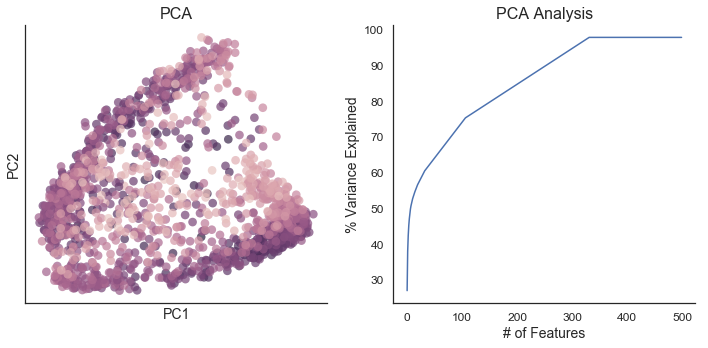

In [69]:
qi_0_PCA500 = fcc_PCA(qi_0.arcsinh_norm(), n_components=500) # 500 component PCA as control
qi_0_PCA500.plot()

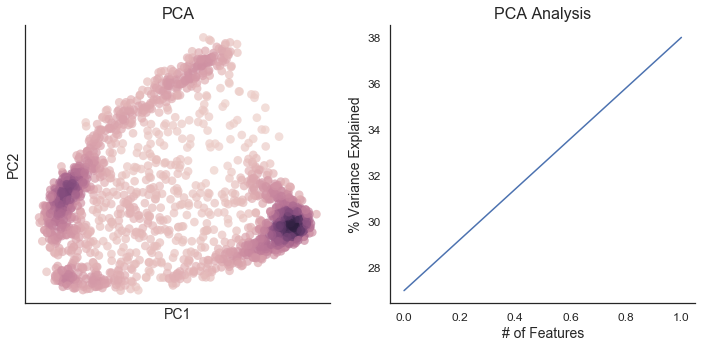

In [70]:
qi_0_PCA2 = fcc_PCA(qi_0.arcsinh_norm(), n_components=2) # 2 component PCA
qi_0_PCA2.plot()

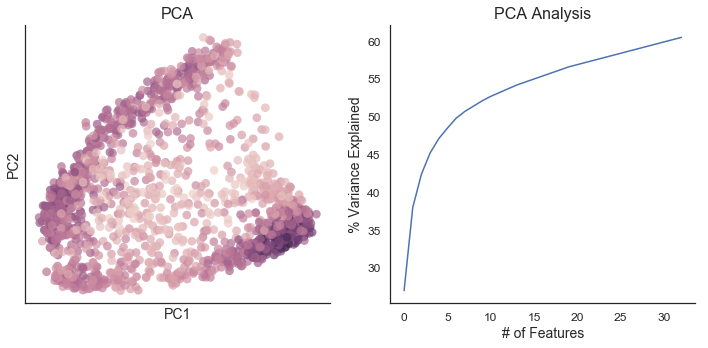

In [71]:
qi_0_PCA33 = fcc_PCA(qi_0.arcsinh_norm(), n_components=33) # 33 component PCA to compare to DCA
qi_0_PCA33.plot()

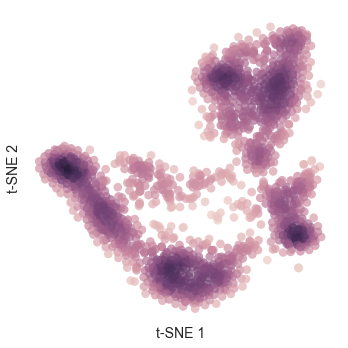

In [72]:
qi_0_tSNE = fcc_tSNE(qi_0.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_tSNE.plot()

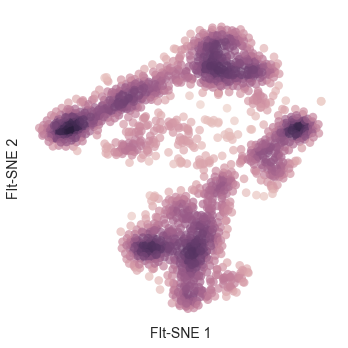

In [73]:
qi_0_FItSNE = fcc_FItSNE(qi_0.arcsinh_norm(), perplexity=30) # FIt-SNE with perplexity 30
qi_0_FItSNE.plot()

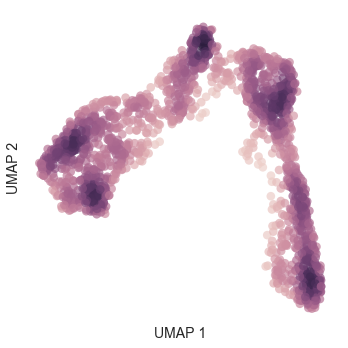

In [74]:
qi_0_UMAP = fcc_UMAP(qi_0.arcsinh_norm(), perplexity=30) # UMAP with perplexity 30
qi_0_UMAP.plot()

In [75]:
qi_0_DCA = fcc_DCA(qi_0.counts, norm=False) # DCA on raw counts

DCA: Successfully preprocessed 500 genes and 1595 cells.
Calculating low dimensional representations...
Calculating reconstructions...


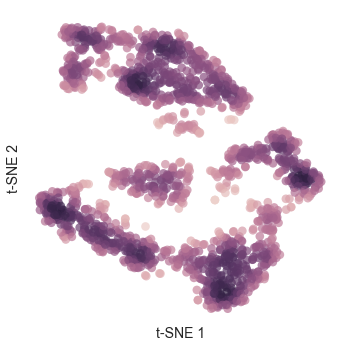

In [76]:
test = RNA_counts(data=qi_0_DCA.results)
qi_0_DCAtSNE = fcc_tSNE(test.arcsinh_norm(), perplexity=30) # t-SNE with perplexity 30
qi_0_DCAtSNE.plot()

---
#### 3.2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

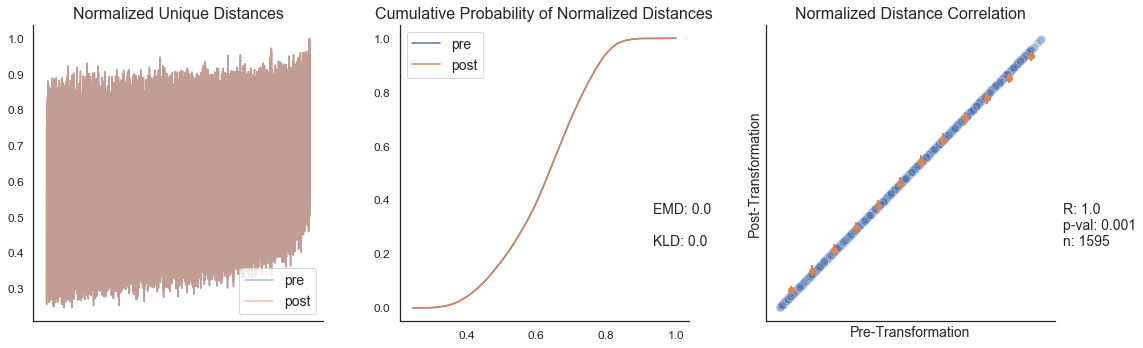

Knn Preservation: 100.0

CPU times: user 1min 33s, sys: 15.3 s, total: 1min 48s
Wall time: 1min 50s


In [77]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA500.knn_graph(k))))

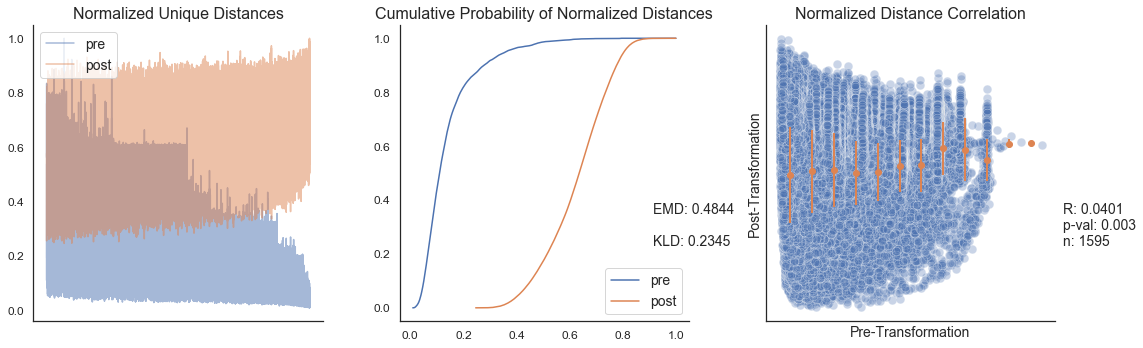

Knn Preservation: 97.1933

CPU times: user 1min 36s, sys: 17.9 s, total: 1min 54s
Wall time: 1min 55s


In [78]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0.knn_graph(k, transform='arcsinh', scale=1000))))

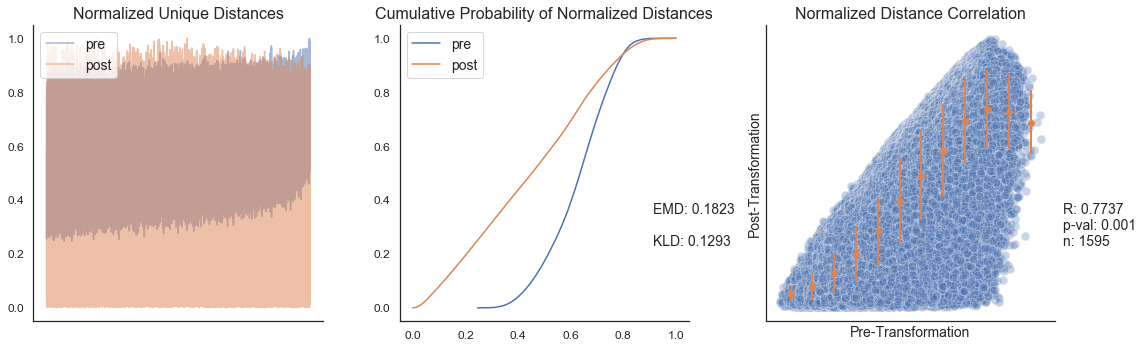

Knn Preservation: 97.7739

CPU times: user 1min 26s, sys: 13.6 s, total: 1min 40s
Wall time: 1min 42s


In [79]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA2.knn_graph(k))))

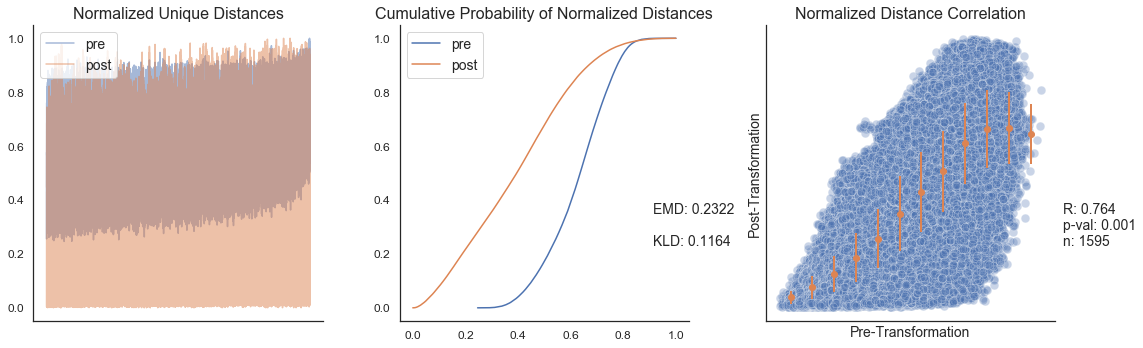

Knn Preservation: 97.6079

CPU times: user 1min 25s, sys: 13.5 s, total: 1min 39s
Wall time: 1min 42s


In [80]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_tSNE.knn_graph(k))))

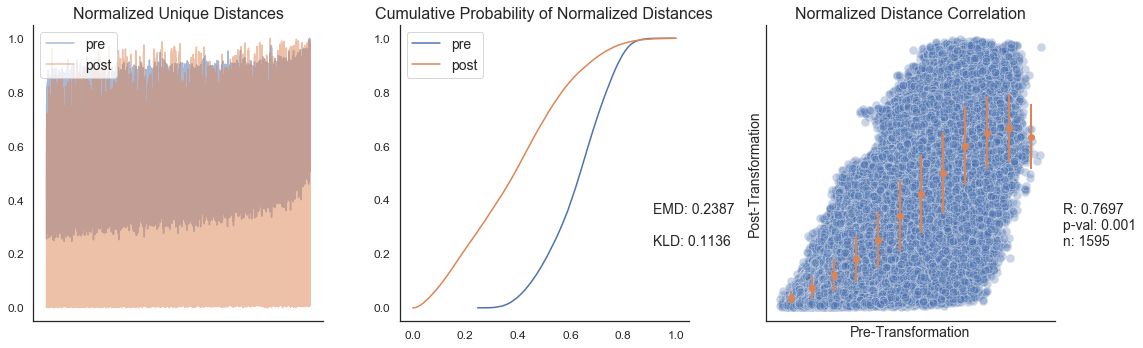

Knn Preservation: 97.6216

CPU times: user 1min 24s, sys: 13.6 s, total: 1min 38s
Wall time: 1min 39s


In [81]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_FItSNE.knn_graph(k))))

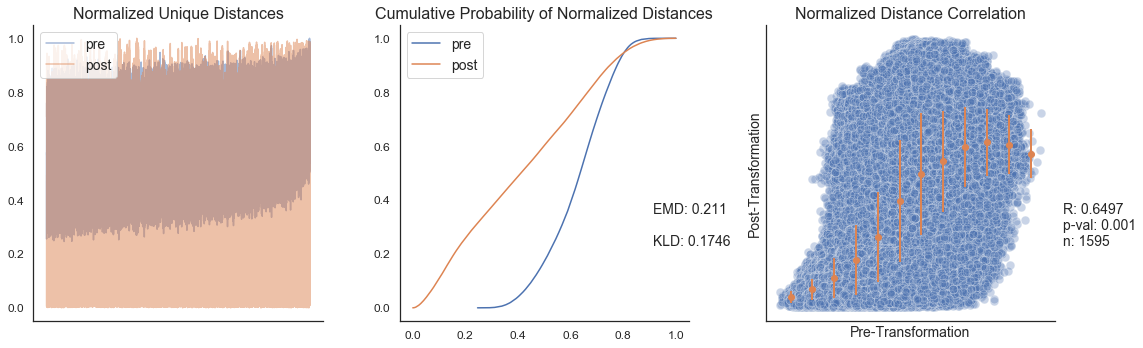

Knn Preservation: 97.4477

CPU times: user 1min 24s, sys: 13.6 s, total: 1min 38s
Wall time: 1min 39s


In [82]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_UMAP.knn_graph(k))))

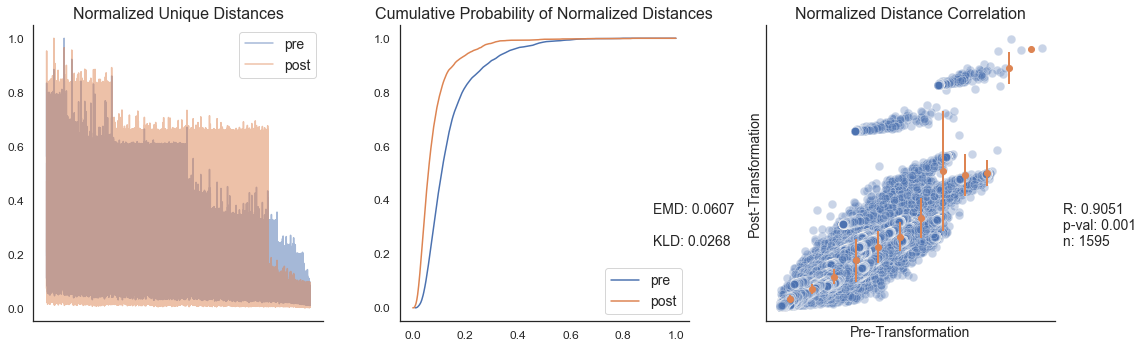

Knn Preservation: 98.2013

CPU times: user 1min 28s, sys: 17.3 s, total: 1min 46s
Wall time: 1min 49s


In [83]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform=None), 
                                  post=qi_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k), 
                                                       post=qi_0_DCA.knn_graph(k))))

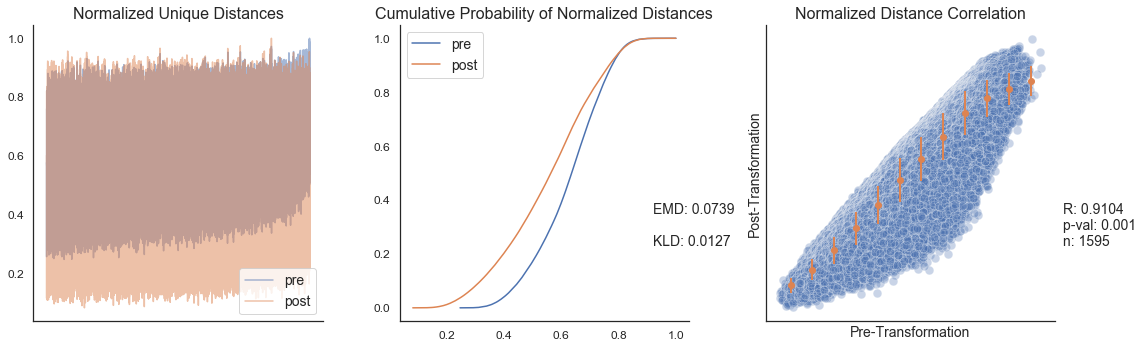

Knn Preservation: 98.3835

CPU times: user 1min 27s, sys: 14.5 s, total: 1min 42s
Wall time: 1min 44s


In [84]:
%%time
# look at 33-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=qi_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=qi_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=qi_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=qi_0_PCA33.knn_graph(k))))